In [116]:
import pandas as pd

In [117]:
df = pd.read_csv('open_mateo_train_test.csv')
df.shape

(1813, 17)

In [118]:
df.columns

Index(['date', 'spoke', 'weather_code', 'working_precipitation', 'rain_sum',
       'showers_sum', 'precipitation_hours', 'year', 'month', 'day', 'weekday',
       'hour', 'net', 'discount', 'total_item_qty', 'total_transaction_qty',
       'transaction_mean_price'],
      dtype='object')

In [119]:
df = df[~df['weather_code'].isin([0, 1, 2, 3, 45, 61,80])]  # Drop specific weather codes
df.shape


(686, 17)

In [120]:
# df = df[~df['weather_code'].isin([0, 1, 2, 3, 45, 61,80])]  # Drop specific weather codes
# df.shape

threshold = df['working_precipitation'].quantile(0.8)
df = df[df['working_precipitation'] >= threshold]
df.shape


(138, 17)

In [121]:
df = df.drop(df[df['spoke'] == 'malate'].nlargest(1, 'net').index)
df.shape
df = df.drop(df[df['spoke'] == 'makati'].nlargest(1, 'net').index)
df.shape

(136, 17)

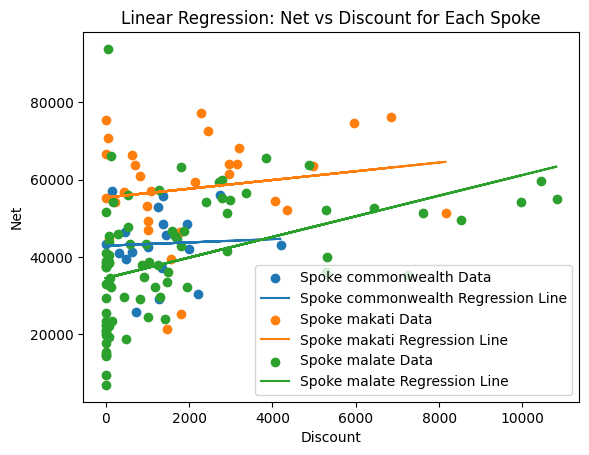

Spoke commonwealth: Net = 0.42 * Discount + 42953.58
Spoke makati: Net = 1.13 * Discount + 55422.20
Spoke malate: Net = 2.67 * Discount + 34553.90


In [123]:
import pandas as pd
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt


# Group the data by 'spoke'
grouped = df.groupby('spoke')

# Initialize a dictionary to store regression results
regression_results = {}

# Iterate over each group (spoke)
for spoke, group in grouped:
    # Prepare X (discount) and y (net)
    X = group['discount'].values.reshape(-1, 1)  # Independent variable
    y = group['net'].values                      # Dependent variable

    # Fit the linear regression model
    model = LinearRegression()
    model.fit(X, y)

    # Store the results
    regression_results[spoke] = {
        'slope': model.coef_[0],
        'intercept': model.intercept_,
        'r_squared': model.score(X, y)  # Optional: R-squared value
    }

    # Optional: Plot the regression line for each spoke
    plt.scatter(X, y, label=f'Spoke {spoke} Data')
    plt.plot(X, model.predict(X), label=f'Spoke {spoke} Regression Line')

# Add labels and legend to the plot
plt.xlabel('Discount')
plt.ylabel('Net')
plt.title('Linear Regression: Net vs Discount for Each Spoke')
plt.legend()
plt.show()

# Print the regression formulas for each spoke
for spoke, results in regression_results.items():
    print(f"Spoke {spoke}: Net = {results['slope']:.2f} * Discount + {results['intercept']:.2f}")

In [124]:
import pandas as pd

# Define the regression formulas for each spoke
def calculate_net(spoke, discount):
    if spoke == 'commonwealth':
        return 0.42 * discount + 42953.58
    elif spoke == 'makati':
        return 1.13  * discount + 55422.20
    elif spoke == 'malate':
        return 2.67 * discount + 34553.90
    else:
        return None  # Handle other spokes if needed

# Compute baseline net income (discount = 0)
df['baseline_net'] = df['spoke'].apply(lambda x: calculate_net(x, 0))

# Compute current net income using actual discount values
df['current_net'] = df.apply(lambda row: calculate_net(row['spoke'], row['discount']), axis=1)

# Compute the impact of discounts
df['discount_impact'] = df['current_net'] - df['baseline_net']


In [125]:
# Calculate percentage earned
df['percentage_earned'] = (df['discount_impact'] / df['baseline_net']) * 100


# Calculate the overall average percentage earned
average_percentage_earned = df['percentage_earned'].mean()

# Calculate the average percentage earned for each spoke
average_percentage_by_spoke = df.groupby('spoke')['percentage_earned'].mean()

# Display the results
print(f"Overall Average Percentage Earned: {average_percentage_earned:.2f}%")
print("\nAverage Percentage Earned by Spoke:")
print(average_percentage_by_spoke)

Overall Average Percentage Earned: 9.17%

Average Percentage Earned by Spoke:
spoke
commonwealth     1.284736
makati           4.419621
malate          12.620071
Name: percentage_earned, dtype: float64


In [84]:
df.describe()

,weather_code,working_precipitation,rain_sum,showers_sum,precipitation_hours,year,month,day,hour,net,discount,total_item_qty,total_transaction_qty,transaction_mean_price,baseline_net,current_net,discount_impact,percentage_earned
count,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.0,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000,136.000000
mean,93.272059,35.161765,9.157353,25.994853,19.514706,2023.286765,7.735294,16.926471,16.0,43875.011471,1710.436618,179.757353,86.235294,504.137670,39720.196912,43806.643988,4086.447076,10.881796
std,5.134440,26.597873,25.798405,10.921344,4.707732,0.698232,1.550318,9.506047,0.0,16166.569761,2299.384697,65.856915,26.836193,90.737428,7939.372464,9616.201857,6121.889166,17.561283
min,81.000000,20.000000,0.000000,8.300000,6.000000,2022.000000,4.000000,1.000000,16.0,6955.340000,0.000000,25.000000,17.000000,339.960351,34430.070000,34430.070000,0.000000,0.000000
25%,95.000000,22.725001,0.000000,20.574998,16.000000,2023.000000,7.000000,9.000000,16.0,32865.815000,81.425000,133.500000,71.250000,444.255412,34430.070000,34674.421800,233.689750,0.660899
50%,95.000000,26.750000,0.000000,23.849999,21.000000,2023.000000,8.000000,19.000000,16.0,43479.070000,995.610000,180.000000,88.000000,500.327227,34430.070000,41194.100500,1958.270000,4.647637
75%,96.000000,32.949998,6.175000,28.824998,24.000000,2024.000000,9.000000,25.000000,16.0,55108.005000,2238.482500,234.500000,106.250000,547.759921,40815.350000,53749.410000,4856.825150,12.434705
max,96.000000,236.099990,225.300000,90.700000,24.000000,2024.000000,12.000000,31.000000,16.0,93835.700000,10819.800000,332.000000,147.000000,1121.932826,53724.810000,67108.850000,31052.826000,90.191005


In [85]:
df_no_rain = df[df['working_precipitation']==0]

In [86]:
df_no_rain

,date,spoke,weather_code,working_precipitation,rain_sum,showers_sum,precipitation_hours,year,month,day,...,hour,net,discount,total_item_qty,total_transaction_qty,transaction_mean_price,baseline_net,current_net,discount_impact,percentage_earned


In [87]:
df_with_rain = df[df['working_precipitation']!=0]

In [33]:
df_with_rain

,date,spoke,weather_code,working_precipitation,rain_sum,showers_sum,precipitation_hours,year,month,day,weekday,hour,net,discount,total_item_qty,total_transaction_qty,transaction_mean_price
3,2024-01-02,commonwealth,80.0,0.6,0.0,0.6,3.0,2024,1,2,Tuesday,16,32642.83,0.00,131.0,68.0,480.041618
10,2024-01-09,commonwealth,3.0,0.2,0.0,0.2,2.0,2024,1,9,Tuesday,16,26654.36,273.10,127.0,64.0,416.474375
19,2024-01-18,commonwealth,45.0,0.1,0.0,0.1,1.0,2024,1,18,Thursday,16,37835.57,255.14,147.0,71.0,532.895352
21,2024-01-20,commonwealth,3.0,0.1,0.0,0.1,1.0,2024,1,20,Saturday,16,25292.90,200.00,100.0,59.0,428.693220
22,2024-01-21,commonwealth,80.0,0.4,0.0,0.4,3.0,2024,1,21,Sunday,16,40680.65,834.69,177.0,89.0,457.085955
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1808,2024-10-25,malate,95.0,5.4,0.0,5.4,6.0,2024,10,25,Friday,16,40096.95,1567.34,162.0,79.0,507.556329
1809,2024-10-26,malate,95.0,9.0,0.0,8.9,17.0,2024,10,26,Saturday,16,27136.52,1229.09,116.0,58.0,467.871034
1810,2024-10-27,malate,3.0,0.1,0.0,0.1,1.0,2024,10,27,Sunday,16,24480.62,1385.68,102.0,51.0,480.012157
1811,2024-10-28,malate,3.0,0.2,0.0,0.2,2.0,2024,10,28,Monday,16,21056.26,50.00,83.0,48.0,438.672083


In [35]:
df_no_rain.describe()

,weather_code,working_precipitation,rain_sum,showers_sum,precipitation_hours,year,month,day,hour,net,discount,total_item_qty,total_transaction_qty,transaction_mean_price
count,608.000000,608.0,608.0,608.0,608.0,608.000000,608.000000,608.000000,608.0,608.000000,608.000000,608.000000,608.000000,608.000000
mean,5.271382,0.0,0.0,0.0,0.0,2023.486842,4.424342,15.203947,16.0,45802.595329,1048.598635,187.810855,86.475329,512.987511
std,10.133558,0.0,0.0,0.0,0.0,0.615418,3.560380,9.043799,0.0,27913.183623,1812.216728,88.854909,35.890682,87.485081
min,1.000000,0.0,0.0,0.0,0.0,2022.000000,1.000000,1.000000,16.0,1845.540000,0.000000,11.000000,6.000000,307.590000
25%,2.000000,0.0,0.0,0.0,0.0,2023.000000,2.000000,7.000000,16.0,30937.485000,71.430000,136.000000,68.000000,456.202882
50%,3.000000,0.0,0.0,0.0,0.0,2024.000000,3.000000,15.000000,16.0,41072.095000,354.715000,173.000000,84.000000,497.308336
75%,3.000000,0.0,0.0,0.0,0.0,2024.000000,5.000000,23.000000,16.0,52779.677500,1202.500000,224.000000,101.000000,548.377118
max,45.000000,0.0,0.0,0.0,0.0,2024.000000,12.000000,31.000000,16.0,229600.810000,11300.000000,700.000000,284.000000,1023.596429


In [34]:
df_with_rain.describe()

,weather_code,working_precipitation,rain_sum,showers_sum,precipitation_hours,year,month,day,hour,net,discount,total_item_qty,total_transaction_qty,transaction_mean_price
count,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000,1205.0,1205.000000,1205.000000,1205.000000,1205.000000,1205.000000
mean,75.385892,9.261660,1.272697,7.976598,10.029876,2023.337759,7.324481,16.068880,16.0,45849.191676,1621.682166,189.862241,87.951867,509.220510
std,30.979411,13.975779,9.204715,9.069749,6.539868,0.694982,2.604642,8.604994,0.0,21369.961395,2455.811975,80.239007,31.716445,81.811318
min,2.000000,0.100000,0.000000,0.000000,1.000000,2022.000000,1.000000,1.000000,16.0,2200.900000,0.000000,9.000000,7.000000,210.430000
25%,80.000000,1.000000,0.000000,0.900000,5.000000,2023.000000,6.000000,9.000000,16.0,33037.530000,81.000000,137.000000,69.000000,454.202800
50%,95.000000,5.400000,0.000000,5.200000,9.000000,2023.000000,8.000000,16.000000,16.0,44606.070000,857.260000,187.000000,88.000000,501.675618
75%,95.000000,12.900001,0.000000,12.100000,14.000000,2024.000000,9.000000,23.000000,16.0,56454.730000,2171.150000,238.000000,106.000000,552.076642
max,96.000000,236.099990,225.300000,90.700000,24.000000,2024.000000,12.000000,31.000000,16.0,209955.440000,37606.140000,662.000000,287.000000,1121.932826
